In [1]:
# MPC (reducing horizon MPC) for Priority-weighted Load Restoration Problem 
    # For Resiliency Improvement in Distribution Systems
# The data analytics (pre-processing amd post-processing) is written in Python
# While the MPC is written in Julia and called from Python

In [2]:
# Import required Python packages/modules

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
#sbn.set()
from datetime import datetime


In [3]:
# Calling Julia Packages from Python
# Install Julia packages required by PyJulia

import julia
from julia.api import Julia
jl = Julia(compiled_modules=False)  
jl = julia.Julia()


Call the MPC written in Julia-JuMP

In [4]:
# Forecast (Wind & PV) Reader 

class ForecastReader:
    def __init__(self, forecast_pointers_file='forecast_pointers.csv'):
        self._forecast_pointers = pd.read_csv(forecast_pointers_file, parse_dates=['Time'],
                                        index_col=0, infer_datetime_format=True).to_dict()['forecast_file']

    def get_forecast(self, datetime):
        '''
        Get the forecast as a pandas dataframe for the datetime
        '''
        k = pd.Timestamp(datetime)

        if k not in self._forecast_pointers:
            raise Exception(f"Datetime {datetime} does not have a forecast available")

        return pd.read_csv(self._forecast_pointers[k], parse_dates=['Time'], index_col=0, infer_datetime_format=True)

    def available_dates(self):
        return self._forecast_pointers.keys()
    

In [5]:
# Get the dates of interest (dates in the control horizon)

# Specify the starting point for the forecasts

Start_index = 31*24*12 + 6*24*12 + 72      # 2019-08-07 06:00
# Define the optimization horizon (6 hours == 72 5-minutes)
num_time_steps = 72
dates_object = ForecastReader()
dates = dates_object.available_dates()
dateslist = list()
for time in dates:
    dateslist.append(time)
datetimes_6h = dateslist[Start_index:Start_index+num_time_steps]

In [6]:
# Get the PV and Wind forecasts
# and put together all the forecasts in all the time steps in the control horizon

# Define the rated capacities (kW) of the renewable generators
wind_max = 150
pv_max = 300

num_time_steps_in_a_day = 288
Pwind_forecast_all = np.empty((0, num_time_steps_in_a_day))
Psolar_forecast_all = np.empty((0, num_time_steps_in_a_day))

for datetime in datetimes_6h:
    # Read the Wind and PV Power Forecasts
    forecast_object = ForecastReader()
    forecast = forecast_object.get_forecast(datetime)
    Pwind = wind_max*np.array(forecast['wind_gen'])
    Pwind_forecast_all = np.append(Pwind_forecast_all, [Pwind], axis=0)
    Psolar = pv_max*np.array(forecast['pv_gen'])
    Psolar_forecast_all = np.append(Psolar_forecast_all, [Psolar], axis=0)


In [7]:
# Read the load demands (constant load time series)
    
Load_dataset = pd.read_csv('Constant_Load_Time_Series.csv', header=0, infer_datetime_format=True, 
                           parse_dates=['Node'], index_col=['Node'])
Load_dataset = np.array(Load_dataset)
Pl_demanded = Load_dataset


In [9]:
# Call/Run the MPC (from Julia)

# Define the number of nodes (loads)

NUM_OF_LOAD_BUS = 10
num_nodes = NUM_OF_LOAD_BUS

# Define the step size

Δt = 5/60

# Define the initial energy/fuel status of the battery and microturbine

battery_SOC = 0.90
mt_energy = 1000

P_restoredd = np.empty((0, num_nodes))
Pmt_genn = ([])
Pbatt = ([])
SOCbatt = ([])
Pwt_cutt = ([])
Ppv_cutt = ([])
Pwt_instant = ([])
Ppv_instant = ([])
muuu = ([])
Pl_instant = np.empty((0, num_nodes))

# Set the initial control horizon

control_horizon = num_time_steps
    
# Set the initial system performance degradation immediately after the disruptions
    # 100% or 0%
    
#Pl_restored = Pl_demanded[:,0]
Pl_restored = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

for i in range(num_time_steps):
    
    # Call/Add the Julia controller
    
    jl.include("mpc_reducing_horizon")
    
    # Get the wind and PV power at this step

    Pwt = Pwind_forecast_all[i, 0:72]
    Ppv = Psolar_forecast_all[i, 0:72]

    # Run the MPC optimization
    
    P_restored, Pmt_gen, Pbat, SOCbat, Pwt_cut, Ppv_cut, Objective_value = jl.execute_mpc(control_horizon, battery_SOC, mt_energy, Pwt, Ppv, Pl_demanded, Pl_restored)
    
    # Apply the first control actions and discard the rest
    
    P_restoredd = np.append(P_restoredd, [P_restored[:,0]], axis=0)
    Pmt_genn = np.append(Pmt_genn, Pmt_gen[0])
    Pbatt = np.append(Pbatt, Pbat[0])
    SOCbatt = np.append(SOCbatt, SOCbat[0])
    Pwt_cutt = np.append(Pwt_cutt, Pwt_cut[0])
    Ppv_cutt = np.append(Ppv_cutt, Ppv_cut[0])
    #muuu = np.append(muuu, muu[0])
    
    # Save the intant (current) values of the loads and RE generations 
        
    Pl_instant = np.append(Pl_instant, [Pl_demanded[:,0]], axis=0)
    Pwt_instant = np.append(Pwt_instant, Pwt[0])
    Ppv_instant = np.append(Ppv_instant, Ppv[0])
    
    # Update the battery SOC and MT fuel status for the next step
    
    battery_SOC = SOCbat[0]
    mt_energy = mt_energy - Pmt_gen[0]*Δt
    
    # Update the restored load for the next step
    
    Pl_restored = np.transpose(P_restored)[0]
    
    # Update (reduce) the control horizon for the next step
    #while control_horizon > 1:
    control_horizon -=1
    
    # END of the for loop
    
Pl_instant = np.transpose(Pl_instant)
P_restoredd = np.transpose(P_restoredd)


In [10]:
# Load demands
    
# Define the base load at each node

Plbase = np.array([33, 34, 8.5, 85, 60, 60, 58, 115, 64, 85])

Pldemanded_t = list()
for i in range(len(Plbase)):
        Pldemanded_t.append([Plbase[i]] * num_time_steps)
Pldemanded_t = np.array(Pldemanded_t)


In [11]:
# Forecasted load demand (real power) at each time step

Actual_Load_Real_t = list()
for ix in range(num_time_steps):
    Load_t = sum(Pl_instant[:,ix])
    Actual_Load_Real_t.append(Load_t)
Actual_Load_Real_t = np.array(Actual_Load_Real_t)

# Forecasted energy demand at each node -- in kWh  
    # (Total energy at a node makes sense for time series loads)

Energy_n = list()
for jx in range(len(Pl_instant)):
    ener_n = sum(Pl_instant[jx,:])*Δt
    Energy_n.append(ener_n)
Energy_n = np.array(Energy_n)


In [12]:
# Restored load at each time step

P_restored_t = list()
for jdx in range(num_time_steps):
    P_restored_t.append(sum(P_restoredd[:,jdx]))
P_restored_t = np.array(P_restored_t)

# Restored energy at each node

E_restored_n = list()
for qdx in range(num_nodes):
    E_restored_n.append((sum(P_restoredd[qdx,:]))*Δt)
E_restored_n = np.array(E_restored_n)


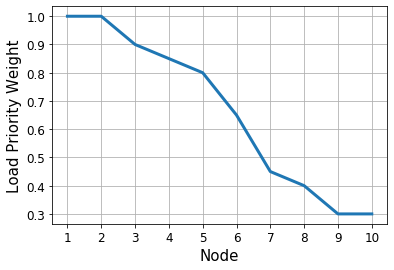

In [13]:
# Plot the Load Priority Weight

load_priority_weight = [1.0, 1.0, 0.9, 0.85, 0.8, 0.65, 0.45, 0.4, 0.3, 0.3]
node_idx = range(NUM_OF_LOAD_BUS)
node_idx = np.array(node_idx)
plt.plot(node_idx, load_priority_weight, linewidth = 3)
plt.xlabel('Node', fontsize=15)
plt.ylabel('Load Priority Weight', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, 10, 1), [str(int(c)) for c in range(1, 11, 1)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()


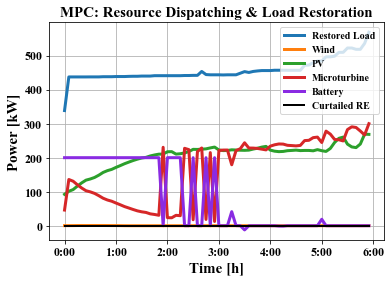

In [14]:
# Plot the results - restored load and dispatch of the controllable resources

t = range(num_time_steps)
t = np.array(t)
plt.plot(t, P_restored_t, label='Restored Load', linewidth = 3)
plt.plot(t, Pwt_instant, label='Wind', linewidth = 3)
plt.plot(t, Ppv_instant, label='PV', linewidth = 3)
plt.plot(t, Pmt_genn, label='Microturbine', linewidth = 3)
plt.plot(t, Pbatt, label='Battery', linewidth = 3, color = 'blueviolet')
plt.plot(t, (Pwt_cutt + Ppv_cutt), label='Curtailed RE', linewidth = 2, color = 'black')
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Power [kW]', fontsize=15)
plt.title('MPC: Resource Dispatching & Load Restoration', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(0, 73, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend()
plt.show()

#plt.savefig('/Users/aeseye/Desktop/AGM-Resilience-Project/RL_v1-vs-MPC-Plots3/MPC: Resource Dispatching & Load Restoration-evening.pdf')


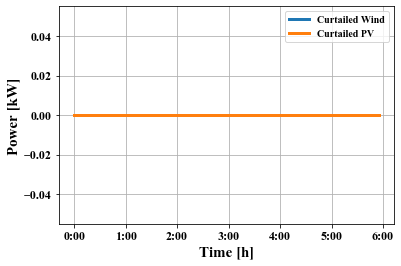

In [15]:
# Plot the renewable power curtailment

t = range(num_time_steps)
t = np.array(t)
plt.plot(t, Pwt_cutt, label='Curtailed Wind', linewidth = 3)
plt.plot(t, Ppv_cutt, label='Curtailed PV', linewidth = 3)
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Power [kW]', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(0, 73, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend()
plt.show()


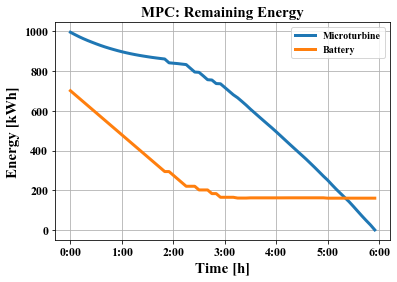

In [17]:
# Change in Energy of Battery and Microturbine

Emt_gen = list()
Emt_gen.append(1000 - Pmt_genn[0]*Δt)
for v in range(1,num_time_steps):
    Emt_gen.append(Emt_gen[v-1] - Pmt_genn[v]*Δt)
Emt_gen = np.array(Emt_gen)

t = range(num_time_steps)
t = np.array(t)
plt.plot(t, Emt_gen, label='Microturbine', linewidth = 3)
plt.plot(t, 800*SOCbatt, label='Battery', linewidth = 3)
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Energy [kWh]', fontsize=15)
plt.title('MPC: Remaining Energy', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(0, 73, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend()
plt.show()

#plt.savefig('/Users/aeseye/Desktop/AGM-Resilience-Project/RL_v1-vs-MPC-Plots3/MPC: Remaining Energ-evening.pdf')

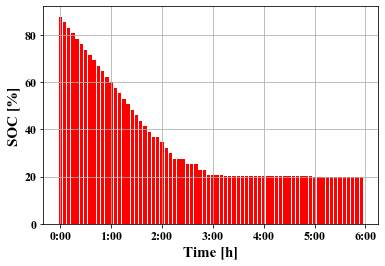

In [18]:
# Plot the battery state of charge (SOC) - %

t = range(num_time_steps)
t = np.array(t)
plt.bar(t,  100*SOCbatt, width = 0.8, color = ['red'])
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('SOC [%]', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(0, 73, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()


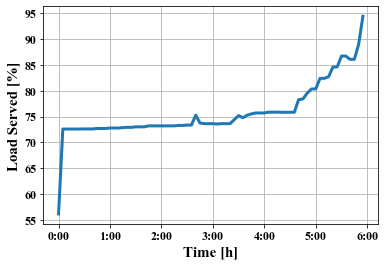

In [19]:
# Plot the percentage of the restored load per time step
    # %Restored Load = Restored Load/Actual Load Demand
    
t = range(num_time_steps)
t = np.array(t)
P_restored_t_perc = (P_restored_t / Actual_Load_Real_t) *100
plt.plot(t, P_restored_t_perc, linewidth = 3)
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Load Served [%]', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(0, 73, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()


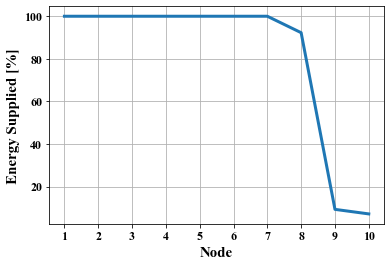

In [20]:
# Plot the percentage of the restored energy per node

n = range(num_nodes)
n = np.array(n)
E_restored_n_perc = (E_restored_n / Energy_n) *100
plt.plot(n, E_restored_n_perc, linewidth = 3)
plt.xlabel('Node', fontsize=15)
plt.ylabel('Energy Supplied [%]', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, 10, 1), [str(int(c)) for c in range(1, 11, 1)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()


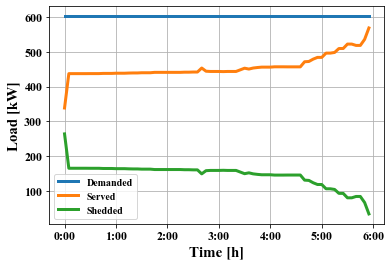

In [21]:
# Plot the actual/original load vs restored load per time step

t = range(num_time_steps)
t = np.array(t)
plt.plot(t, Actual_Load_Real_t, label='Demanded', linewidth = 3)
plt.plot(t, P_restored_t, label='Served', linewidth = 3)
plt.plot(t, (Actual_Load_Real_t - P_restored_t), label='Shedded', linewidth = 3)
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Load [kW]', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(0, 73, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend()
plt.show()

#plt.savefig('/Users/aeseye/Desktop/AGM-Resilience-Project/RL_v1-vs-MPC-Plots3/MPC - Total Demanded vs Served Load-evening.pdf')


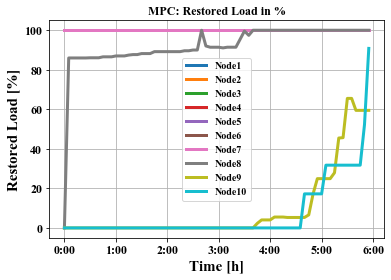

In [22]:
# Plot the percentage of the restored load per time step and node
    # %Restored Load = Restored Load/Actual Load Demand
    
t = range(num_time_steps)
t = np.array(t)
P_restored_t_perc = (P_restoredd / Pl_demanded[:,0:72]) *100
Nodes = ['Node1','Node2','Node3','Node4','Node5','Node6','Node7','Node8','Node9','Node10']
for dx in range(len(P_restored_t_perc)):
    plt.plot(t, P_restored_t_perc[dx], label = Nodes[dx], linewidth = 3)
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Restored Load [%]', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(0, 73, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.title('MPC: Restored Load in %')
plt.grid()
plt.legend()
plt.show()

#plt.savefig('/Users/aeseye/Desktop/AGM-Resilience-Project/RL_v1-vs-MPC-Plots3/MPC: Restored Load in %-evening.pdf')


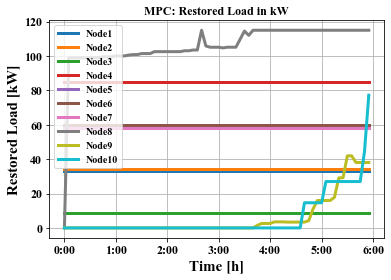

In [23]:
# Plot the actual/original load vs restored load per time step for each node

t = range(num_time_steps)
t = np.array(t)
Nodes = ['Node1','Node2','Node3','Node4','Node5','Node6','Node7','Node8','Node9','Node10']
for dx in range(len(P_restoredd)):
    plt.plot(t, P_restoredd[dx], label = Nodes[dx], linewidth = 3)
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Restored Load [kW]', fontsize=15)
plt.title('MPC: Restored Load in kW')
plt.tick_params(labelsize=12)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(0, 73, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend()
plt.show()

#plt.savefig('/Users/aeseye/Desktop/AGM-Resilience-Project/RL_v1-vs-MPC-Plots3/MPC: Restored Load in kW-evening.pdf')


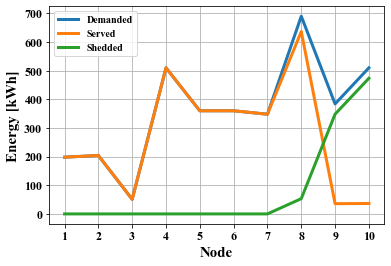

In [24]:
# Plot the actual/original energy vs restored energy per node

n = range(num_nodes)
n = np.array(n)
plt.plot(n, Energy_n, label='Demanded', linewidth = 3)
plt.plot(n, E_restored_n, label='Served', linewidth = 3)
plt.plot(n, (Energy_n - E_restored_n), label='Shedded', linewidth = 3)
plt.xlabel('Node', fontsize=15)
plt.ylabel('Energy [kWh]', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, 10, 1), [str(int(c)) for c in range(1, 11, 1)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend()
plt.show()

#plt.savefig('/Users/aeseye/Desktop/AGM-Resilience-Project/RL_v1-vs-MPC-Plots3/MPC - Demanded vs Served Energy-evening.pdf')


In [25]:
Priorized_total_restored_load = Δt*sum(np.dot(load_priority_weight, P_restoredd))
print("Priorized_total_restored_load: ", Priorized_total_restored_load)

Priorized_total_restored_load:  1836.318981747232


In [26]:
# Penalty for gradual increase in load shedding

psi = 100

l1 = ([])
for pp in range(1,len(P_restoredd[0])):
    if P_restoredd[0][pp] >= P_restoredd[0][pp-1]:
        dd = 0
        l1 = np.append(l1, dd)
    if P_restoredd[0][pp] < P_restoredd[0][pp-1]:
        dd = P_restoredd[0][pp-1] - P_restoredd[0][pp]
        l1 = np.append(l1, dd)
penalty1 = Δt*psi*load_priority_weight[0]*sum(l1)

l2 = ([])
for pp in range(1,len(P_restoredd[1])):
    if P_restoredd[1][pp] >= P_restoredd[1][pp-1]:
        dd = 0
        l2 = np.append(l2, dd)
    if P_restoredd[1][pp] < P_restoredd[1][pp-1]:
        dd = P_restoredd[1][pp-1] - P_restoredd[1][pp]
        l2 = np.append(l2, dd)
penalty2 = Δt*psi*load_priority_weight[1]*sum(l2)

l3 = ([])
for pp in range(1,len(P_restoredd[2])):
    if P_restoredd[2][pp] >= P_restoredd[2][pp-1]:
        dd = 0
        l3 = np.append(l3, dd)
    if P_restoredd[2][pp] < P_restoredd[2][pp-1]:
        dd = P_restoredd[2][pp-1] - P_restoredd[2][pp]
        l3 = np.append(l3, dd)
penalty3 = Δt*psi*load_priority_weight[2]*sum(l3)


l4 = ([])
for pp in range(1,len(P_restoredd[3])):
    if P_restoredd[3][pp] >= P_restoredd[3][pp-1]:
        dd = 0
        l4 = np.append(l4, dd)
    if P_restoredd[3][pp] < P_restoredd[3][pp-1]:
        dd = P_restoredd[3][pp-1] - P_restoredd[3][pp]
        l4 = np.append(l4, dd)
penalty4 = Δt*psi*load_priority_weight[3]*sum(l4)

l5 = ([])
for pp in range(1,len(P_restoredd[4])):
    if P_restoredd[4][pp] >= P_restoredd[4][pp-1]:
        dd = 0
        l5 = np.append(l5, dd)
    if P_restoredd[4][pp] < P_restoredd[4][pp-1]:
        dd = P_restoredd[4][pp-1] - P_restoredd[4][pp]
        l5 = np.append(l5, dd)
penalty5 = Δt*psi*load_priority_weight[4]*sum(l5)

l6 = ([])
for pp in range(1,len(P_restoredd[5])):
    if P_restoredd[5][pp] >= P_restoredd[5][pp-1]:
        dd = 0
        l6 = np.append(l6, dd)
    if P_restoredd[5][pp] < P_restoredd[5][pp-1]:
        dd = P_restoredd[5][pp-1] - P_restoredd[5][pp]
        l6 = np.append(l6, dd)
penalty6 = Δt*psi*load_priority_weight[5]*sum(l6)

l7 = ([])
for pp in range(1,len(P_restoredd[6])):
    if P_restoredd[6][pp] >= P_restoredd[6][pp-1]:
        dd = 0
        l7 = np.append(l7, dd)
    if P_restoredd[6][pp] < P_restoredd[6][pp-1]:
        dd = P_restoredd[6][pp-1] - P_restoredd[6][pp]
        l7 = np.append(l7, dd)
penalty7 = Δt*psi*load_priority_weight[6]*sum(l7)

l8 = ([])
for pp in range(1,len(P_restoredd[7])):
    if P_restoredd[7][pp] >= P_restoredd[7][pp-1]:
        dd = 0
        l8 = np.append(l8, dd)
    if P_restoredd[7][pp] < P_restoredd[7][pp-1]:
        dd = P_restoredd[7][pp-1] - P_restoredd[7][pp]
        l8 = np.append(l8, dd)
penalty8 = Δt*psi*load_priority_weight[7]*sum(l8)

l9 = ([])
for pp in range(1,len(P_restoredd[8])):
    if P_restoredd[8][pp] >= P_restoredd[8][pp-1]:
        dd = 0
        l9 = np.append(l9, dd)
    if P_restoredd[8][pp] < P_restoredd[8][pp-1]:
        dd = P_restoredd[8][pp-1] - P_restoredd[8][pp]
        l9 = np.append(l9, dd)
penalty9 = Δt*psi*load_priority_weight[8]*sum(l9)

l10 = ([])
for pp in range(1,len(P_restoredd[9])):
    if P_restoredd[9][pp] >= P_restoredd[9][pp-1]:
        dd = 0
        l10 = np.append(l10, dd)
    if P_restoredd[9][pp] < P_restoredd[9][pp-1]:
        dd = P_restoredd[9][pp-1] - P_restoredd[9][pp]
        l10 = np.append(l10, dd)
penalty10 = Δt*psi*load_priority_weight[9]*sum(l10)

LoadSheddingInceasePenalties = [penalty1, penalty2, penalty3, penalty4, penalty5, penalty6, penalty7, penalty8, penalty9, penalty10]

# Total Penalty

LoadSheddingInceasePenalty = sum(LoadSheddingInceasePenalties)

print("LoadSheddingInceasePenalty: ", LoadSheddingInceasePenalty)


LoadSheddingInceasePenalty:  52.526920547718554


In [27]:
alpha = 0.2  #$/kWh
Penalized_total_wind_curtailment = alpha*sum(Pwt_cutt)*Δt
print("Wind Curtailment Penalty", Penalized_total_wind_curtailment)

Wind Curtailment Penalty 0.0


In [28]:
beta = 0.2  #$/kWh
Penalized_total_pv_curtailment = beta*sum(Ppv_cutt[1:num_time_steps])*Δt
print("PV Curtailment Penalty", Penalized_total_pv_curtailment)

PV Curtailment Penalty 0.0


In [29]:
# Objective Function Value

Objective_fn_value = Priorized_total_restored_load - LoadSheddingInceasePenalty - Penalized_total_wind_curtailment - Penalized_total_pv_curtailment
print("Objective Function Value: ", Objective_fn_value)

Objective Function Value:  1783.7920611995135


In [30]:
# Create dataframe containing the decisions

# Decisions

time_index = pd.date_range(start ='2019-08-01 12:00', freq ='5min', periods = 72) 
 
decisions = {'Time': time_index,
             'Restored Load': P_restored_t,
             'Wind Power': Pwt_instant,
             'PV Power': Ppv_instant,
             'Microturbine Power': Pmt_genn,
             'Energy Storage Power': Pbatt,
             'Curtailed Renewable Power': (Pwt_cutt + Ppv_cutt)
            }

df1 = pd.DataFrame(decisions, columns = ['Time', 'Restored Load', 'Wind Power', 'PV Power', 'Microturbine Power', 'Energy Storage Power', 'Curtailed Renewable Power'])

#print (df1)

# Export/save the decisions to csv

#df1.to_csv('MPC_decisions_Aug1_Noon_to_Evening-new.csv')


# Restored Loads in kW

restored_loads_kW = {'Time': time_index,
                     'Load1': P_restoredd[0],
                     'Load2': P_restoredd[1],
                     'Load3': P_restoredd[2],
                     'Load4': P_restoredd[3],
                     'Load5': P_restoredd[4],
                     'Load6': P_restoredd[5],
                     'Load7': P_restoredd[6],
                     'Load8': P_restoredd[7],
                     'Load9': P_restoredd[8],
                     'Load10': P_restoredd[9]
                    }

df2 = pd.DataFrame(restored_loads_kW, columns = ['Time', 'Load1','Load2','Load3','Load4','Load5','Load6','Load7','Load8','Load9','Load10'])

#print (df2)

# Export/save it to csv

#df2.to_csv('MPC_restored_loads_kW_Aug1_Noon_to_Evening-new.csv')


# Restored Loads in %

restored_loads_perc = {'Time': time_index,
                       'Load1': P_restored_t_perc[0],
                       'Load2': P_restored_t_perc[1],
                       'Load3': P_restored_t_perc[2],
                       'Load4': P_restored_t_perc[3],
                       'Load5': P_restored_t_perc[4],
                       'Load6': P_restored_t_perc[5],
                       'Load7': P_restored_t_perc[6],
                       'Load8': P_restored_t_perc[7],
                       'Load9': P_restored_t_perc[8],
                       'Load10': P_restored_t_perc[9]
                      }

df3 = pd.DataFrame(restored_loads_perc, columns = ['Time', 'Load1','Load2','Load3','Load4','Load5','Load6','Load7','Load8','Load9','Load10'])

#print (df3)

# Export/save it to csv

#df3.to_csv('MPC_restored_loads_perc_Aug1_Noon_to_Evening-new.csv')


# Remaining Energy from Micrturbine and Energy storage

remaining_energy_mt_bat = {'Time': time_index,
                           'Microturbine': Emt_gen,
                           'Battery': 800*SOCbatt
                          }

df4 = pd.DataFrame(remaining_energy_mt_bat, columns = ['Time', 'Microturbine','Battery'])

#print (df4)

# Export/save it to csv

#df4.to_csv('MPC_remaining_energy_Aug1_Noon_to_Evening-new.csv')

# Demanded vs Served Energy Per Node

Nodes = ['Node1','Node2','Node3','Node4','Node5','Node6','Node7','Node8','Node9','Node10']
demanded_vs_restored_energy = {'Node': Nodes,
                               'Demanded': Energy_n,
                               'Served': E_restored_n,
                               'Shedded': (Energy_n - E_restored_n)
                              }

df5 = pd.DataFrame(demanded_vs_restored_energy, columns = ['Node', 'Demanded','Served', 'Shedded'])

#print(df5)

# Export/save it to csv

#df5.to_csv('MPC_demanded_vs_restored_energy_Aug1_Noon_to_Evening-new.csv')
